# Ensemble: prra_siconc & prsn_siconc (over sea-ice)

## Imports & defaults

In [1]:
import libs.local
import libs.plot
import libs.vars
import matplotlib

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'prra_siconc'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = 'rainfall (dashed) and snowfall (solid) over sea-ice'
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'
time_series_y_range = (0, 1)
time_series_y_range_monthly = (0, 2)
time_series_process = lambda x: x

In [3]:
ensemble_prra_time_series = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment)
)
ensemble_prra_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series(variable_id, experiment, suffix='_smooth')
)
for variable in ensemble_prra_time_series:
    ensemble_prra_time_series[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    ensemble_prra_time_series_smooth[variable].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

ensemble_prsn_time_series = time_series_process(
    libs.local.get_ensemble_series('prsn_siconc', experiment)
)
ensemble_prsn_time_series_smooth = time_series_process(
    libs.local.get_ensemble_series('prsn_siconc', experiment, suffix='_smooth')
)

time_slices = libs.vars.default_time_slices()

## Time series

### Mean

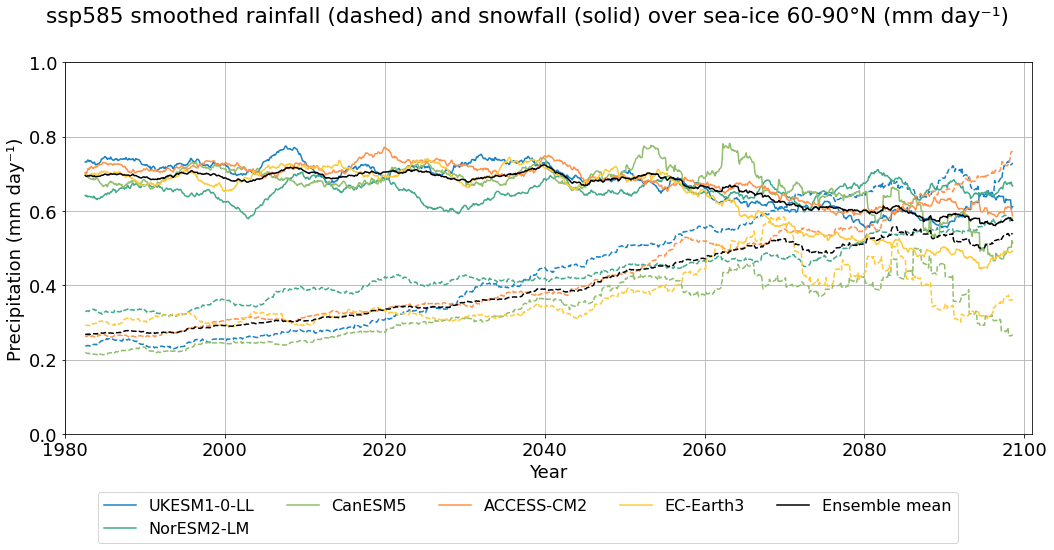

In [4]:
libs.plot.time_series_from_vars(
    [
        ensemble_prsn_time_series_smooth,
        ensemble_prra_time_series_smooth
    ],
    title=f'{experiment} smoothed {time_series_text} 60-90°N ({time_series_units})',
    xattr='time',
    ylabel=time_series_y_label,
    yrange=time_series_y_range
)

## Monthly variability

### Full region (time)

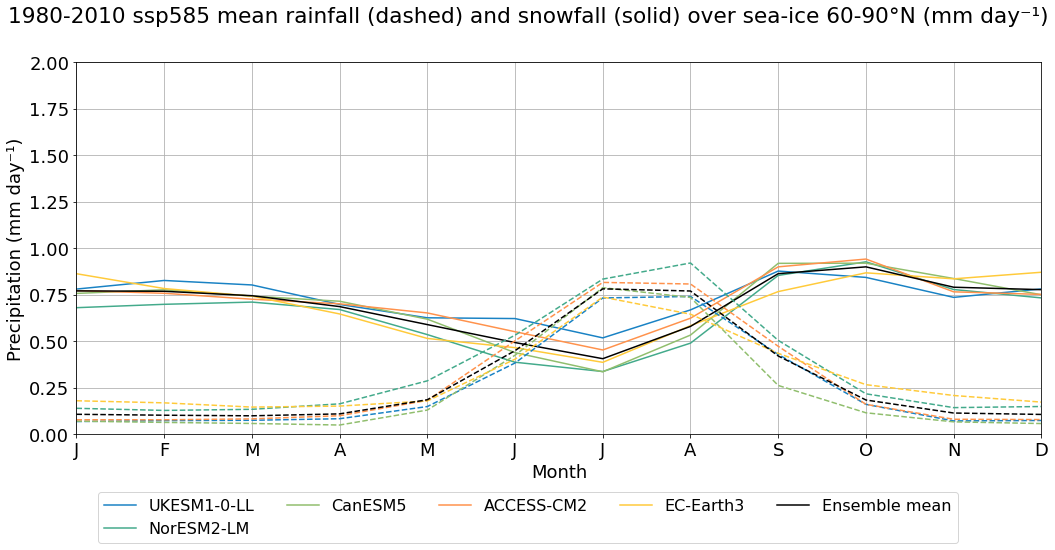

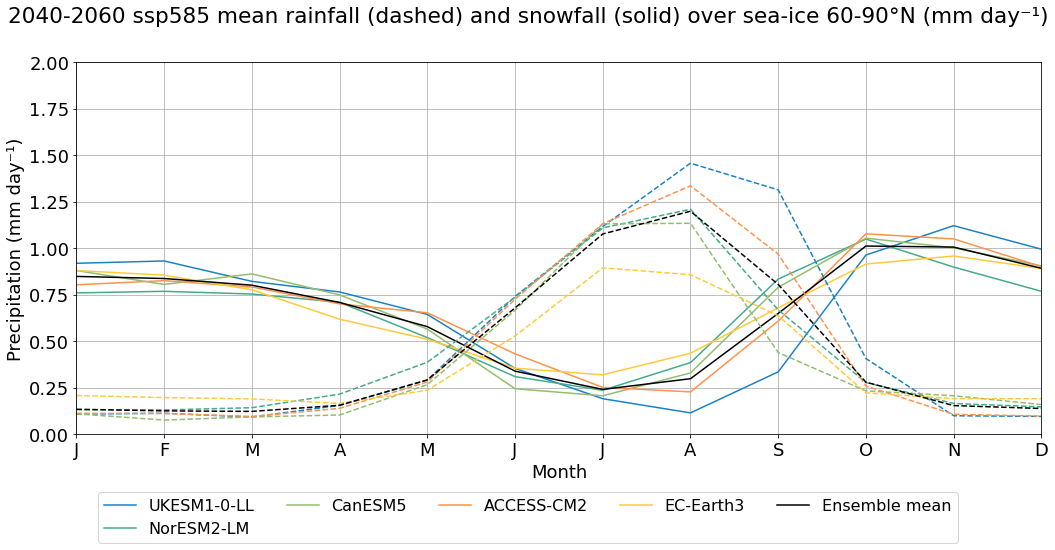

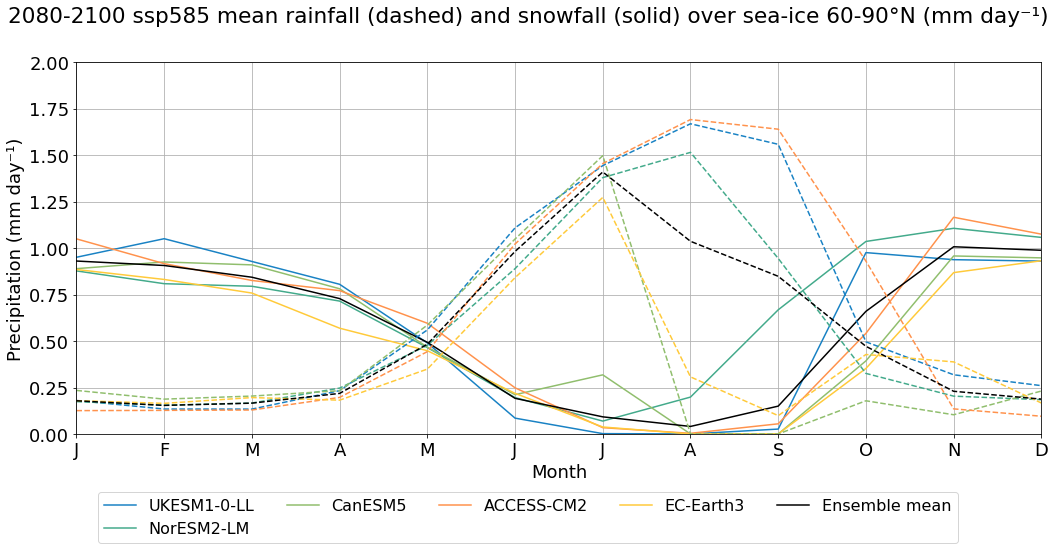

In [5]:
for s in time_slices:
    s_label = s['label']

    libs.plot.monthly_variability(
        [
            ensemble_prsn_time_series.sel(**s['slice']).groupby('time.month').mean('time'),
            ensemble_prra_time_series.sel(**s['slice']).groupby('time.month').mean('time')
        ],
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    )